# 🔍 Système de recommandation classique - Projet M2SC

Ce notebook permet de tester un système de recommandation classique (type **content-based**) à partir d’un dataset de voyages. Il est destiné à être comparé avec les recommandations générées par un LLM.

In [1]:
# 📥 Import des bibliothèques
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 📂 Chargement du dataset
df = pd.read_csv('Travel_details_dataset.csv')  # ← à remplacer par le nom réel du fichier
df.head()

,Trip ID,Destination,Start date,End date,Duration (days),Traveler name,Traveler age,Traveler gender,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost
0,1,"London, UK",5/1/2023,5/8/2023,7.0,John Smith,35.0,Male,American,Hotel,1200,Flight,600
1,2,"Phuket, Thailand",6/15/2023,6/20/2023,5.0,Jane Doe,28.0,Female,Canadian,Resort,800,Flight,500
2,3,"Bali, Indonesia",7/1/2023,7/8/2023,7.0,David Lee,45.0,Male,Korean,Villa,1000,Flight,700
3,4,"New York, USA",8/15/2023,8/29/2023,14.0,Sarah Johnson,29.0,Female,British,Hotel,2000,Flight,1000
4,5,"Tokyo, Japan",9/10/2023,9/17/2023,7.0,Kim Nguyen,26.0,Female,Vietnamese,Airbnb,700,Train,200


In [2]:
# ✅ Sauvegarde des noms de destinations avant encodage
df['Destination_nom'] = df['Destination']  # noms textuels avant transformation

# ⚙️ Encodage des variables catégorielles
categorical_cols = ['Destination', 'Accommodation type', 'Transportation type']
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col].astype(str))

# 🧼 Nettoyage des colonnes de prix : suppression des symboles et conversion
import re
import numpy as np

for col in ['Accommodation cost', 'Transportation cost']:
    df[col] = (
        df[col]
        .astype(str)
        .apply(lambda x: re.sub(r'[^\d.,]', '', x))  # garder que chiffres et ponctuation
        .replace('', np.nan)                         # remplacer vide par NaN
        .str.replace(',', '.')
        .astype(float)
    )

# 🎯 Sélection des colonnes utiles
features = ['Destination', 'Duration (days)', 'Accommodation cost', 'Transportation cost',
            'Accommodation type', 'Transportation type']

# 🔢 Normalisation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df[features])


In [4]:
# 🔁 Récupérer les vrais noms depuis l'encodeur LabelEncoder
df['Destination_nom'] = df['Destination']  # ← ici on garde les vrais noms

df['Destination_nom'] = df['Destination'].apply(lambda x: encoders['Destination'].inverse_transform([int(x)])[0])
df['Destination'] = encoders['Destination'].fit_transform(df['Destination'].astype(str))

# 🏆 Affichage final lisible avec noms
df.sort_values('similarité', ascending=False)[['Destination_nom', 'similarité']].head(5)


,Destination_nom,similarité
30,Australia,0.896870
54,"Bangkok, Thailand",0.851389
92,Bali,0.848340
31,Brazil,0.834123
3,"New York, USA",0.801579


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# 🔍 Nettoyage : enlever les lignes contenant des NaN dans les features utilisées
df = df.dropna(subset=features)

# 🙋‍♂️ Exemple de profil utilisateur (⚠️ les valeurs doivent exister dans ton dataset encodé)
profil_utilisateur = {
    'Destination': 0,               # à adapter selon l'encodage
    'Duration (days)': 7,
    'Accommodation cost': 500,
    'Transportation cost': 300,
    'Accommodation type': 1,       # ex: hôtel
    'Transportation type': 0       # ex: avion
}

# 🧪 Vérification du profil
for k, v in profil_utilisateur.items():
    if pd.isna(v):
        raise ValueError(f"Champ {k} non défini ou invalide dans le profil utilisateur.")

# 🧮 Transformation en vecteur normalisé
profil_vect = scaler.transform([list(profil_utilisateur.values())])

# 🤖 Calcul de similarité cosinus
X_clean = scaler.transform(df[features])  # Re-transforme X propre
similarities = cosine_similarity(X_clean, profil_vect).flatten()

# 🏷️ Ajout des scores au dataframe
df['similarité'] = similarities

# 🏆 Top 5 recommandations
df.sort_values('similarité', ascending=False)[[
    'Destination_nom',
    'Duration (days)',
    'Accommodation cost',
    'Transportation cost',
    'similarité'
]].head(5)


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,Destination_nom,Duration (days),Accommodation cost,Transportation cost,similarité
31,Brazil,9.0,150.0,50.0,0.893583
76,"Cape Town, SA",9.0,400.0,300.0,0.831116
3,"New York, USA",14.0,2000.0,1000.0,0.825459
130,"Cape Town, South Africa",9.0,3000.0,2000.0,0.815027
30,Australia,13.0,1.0,500.0,0.785133


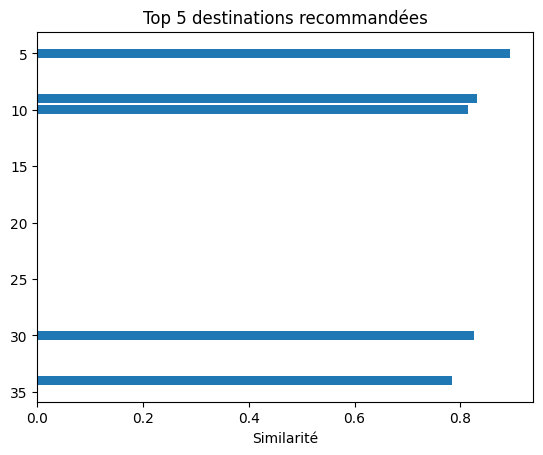

In [8]:
# 📊 Affichage graphique des similarités
import matplotlib.pyplot as plt
top5 = df.sort_values('similarité', ascending=False).head(5)
plt.barh(top5['Destination'], top5['similarité'])
plt.xlabel('Similarité')
plt.title('Top 5 destinations recommandées')
plt.gca().invert_yaxis()
plt.show()

In [9]:
# ✅ Affichage final avec noms clairs
df.sort_values('similarité', ascending=False)[['Destination_nom', 'similarité']].head(5)


,Destination_nom,similarité
31,Brazil,0.893583
76,"Cape Town, SA",0.831116
3,"New York, USA",0.825459
130,"Cape Town, South Africa",0.815027
30,Australia,0.785133


### Profil famille

In [10]:
profil_utilisateur = {
    'Destination': 0,                # Peu importe ici (sert juste au format, sera ignoré dans le tri final)
    'Duration (days)': 14,
    'Accommodation cost': 3000,
    'Transportation cost': 2000,
    'Accommodation type': 1,        # ex: hôtel
    'Transportation type': 0        # ex: avion
}

# Vérification + transformation + calcul
for k, v in profil_utilisateur.items():
    if pd.isna(v):
        raise ValueError(f"Champ {k} non défini ou invalide dans le profil utilisateur.")

profil_vect = scaler.transform([list(profil_utilisateur.values())])
X_clean = scaler.transform(df[features])
similarities = cosine_similarity(X_clean, profil_vect).flatten()
df['similarité'] = similarities

# Affichage clair avec noms + infos
df.sort_values('similarité', ascending=False)[[
    'Destination_nom',
    'Duration (days)',
    'Accommodation cost',
    'Transportation cost',
    'similarité'
]].head(5)


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,Destination_nom,Duration (days),Accommodation cost,Transportation cost,similarité
130,"Cape Town, South Africa",9.0,3000.0,2000.0,0.872582
76,"Cape Town, SA",9.0,400.0,300.0,0.789170
3,"New York, USA",14.0,2000.0,1000.0,0.785278
37,Canada,7.0,350.0,75.0,0.738145
31,Brazil,9.0,150.0,50.0,0.737071


### Profil étudiant

In [ ]:
profil_utilisateur = {
    'Destination': 0,                # Valeur neutre juste pour la forme
    'Duration (days)': 4,
    'Accommodation cost': 120,
    'Transportation cost': 80,
    'Accommodation type': 2,        # Exemple : 2 = auberge ou Airbnb
    'Transportation type': 1        # Exemple : 1 = train
}

# Vérif + calcul + tri
for k, v in profil_utilisateur.items():
    if pd.isna(v):
        raise ValueError(f"Champ {k} non défini ou invalide dans le profil utilisateur.")

profil_vect = scaler.transform([list(profil_utilisateur.values())])
X_clean = scaler.transform(df[features])
similarities = cosine_similarity(X_clean, profil_vect).flatten()
df['similarité'] = similarities

# Affichage clair
df.sort_values('similarité', ascending=False)[[
    'Destination_nom',
    'Duration (days)',
    'Accommodation cost',
    'Transportation cost',
    'similarité'
]].head(5)


In [12]:
profil_utilisateur = {
    'Destination': 0,                # Valeur neutre juste pour la forme
    'Duration (days)': 4,
    'Accommodation cost': 120,
    'Transportation cost': 80,
    'Accommodation type': 2,        # Exemple : 2 = auberge ou Airbnb
    'Transportation type': 1        # Exemple : 1 = train
}

# 🔍 Filtrage avant similarité : on garde les destinations compatibles avec le profil
budget_max_acco = profil_utilisateur['Accommodation cost'] * 1.5
budget_max_trans = profil_utilisateur['Transportation cost'] * 1.5

df_filtré = df[
    (df['Accommodation cost'] <= budget_max_acco) &
    (df['Transportation cost'] <= budget_max_trans)
].copy()


# Vérif + calcul + tri
for k, v in profil_utilisateur.items():
    if pd.isna(v):
        raise ValueError(f"Champ {k} non défini ou invalide dans le profil utilisateur.")

profil_vect = scaler.transform([list(profil_utilisateur.values())])
X_clean = scaler.transform(df[features])
similarities = cosine_similarity(X_clean, profil_vect).flatten()
df['similarité'] = similarities

# Affichage clair
df_filtré.sort_values('similarité', ascending=False)[[
    'Destination_nom',
    'Duration (days)',
    'Accommodation cost',
    'Transportation cost',
    'similarité'
]].head(5)


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,Destination_nom,Duration (days),Accommodation cost,Transportation cost,similarité
103,Bali,6.0,1.2,1.0,0.703494
24,Paris,6.0,1.4,100.0,0.552135
35,Italy,6.0,180.0,120.0,0.510979
31,Brazil,9.0,150.0,50.0,0.166569
